In [1]:
%load_ext autoreload
%autoreload 2

# to enable imports from parent package
import sys
import os
from pathlib import Path
parent_dir = Path(os. getcwd()).parent.absolute()
sys.path.append(str(parent_dir))

import torch
import numpy as np
import os.path as osp
import pandas as pd
import seaborn as sns

from plots import aggregate_over_splits, remove_unused_categories, palette, model_types, group, remove_top_percentage, groupby_to_table, rename_col, concatenate, compute_baseline_score, append_model_type
from attacks.data_recorder import compute_regression_metrics

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Liberation Sans']})
import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt



device = ('cuda' if torch.cuda.is_available() else
          'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}')


plots_dir = 'output'
dataset_name = "IMDB-MULTI"

textwidth = 5.07086
textheight = 8.27615


Device: cuda


In [2]:
from tqdm import tqdm
from run_attacks import all_tasks

results_directory = '../results/'

# tasks_to_load = ["original", "bruteforce"]
# filter_tasks = lambda tasks: {task: val for task, val in tasks.items() if any(t in task for t in tasks_to_load)}
# attack_tasks = {model_name: filter_tasks(val) for model_name, val in all_tasks.items()}

# attack_tasks = all_tasks

def load_data(all_tasks, dataset_name, tasks_to_load=[], sortby=["model", "task", "id"], apply_transform=None):
    data = []

    if tasks_to_load:
        filter_tasks = lambda tasks: {task: val for task, val in tasks.items() if any(t in task for t in tasks_to_load)}
        all_tasks = {model_name: filter_tasks(val) for model_name, val in all_tasks.items() if dataset_name in model_name}

    for model_name, tasks in tqdm(all_tasks.items()):
        # if not dataset_name in model_name:
        #     continue
        model_type = model_name.split("_")[0]
        dataset = model_name.split("_")[1]

        for task_name, task in tasks.items():
            path = osp.join(results_directory, dataset, model_name, f"{task_name}.data")
            if not osp.exists(path):
                continue

            df = pd.read_pickle(path)
            if apply_transform is not None:
                    df = apply_transform(df)
            data.append(df)
            # try:
            #     df = pd.read_pickle(path)
            #     if apply_transform is not None:
            #          df = apply_transform(df)
            #     data.append(df)
            # except Exception as e:
            #     print(f"ERROR when reading task '{task_name}' of '{model_name}'")
            #     print(e)

    def short_model_names_map(df, prefix_len=1):
        model_names = set(df["model"].values)
        count = {}
        rename_map = {}
        for model_name in model_names:
            prefix = "_".join(model_name.split("_")[:prefix_len])
            if not prefix in count:
                count[prefix] = 0
            rename_map[model_name] = f"{prefix}_{count[prefix]}"
            count[prefix] += 1
        return rename_map

    data = concatenate(data)
    data.sort_values(sortby, inplace=True)
    data = data.reset_index(drop=True)
    model_name_map = short_model_names_map(data)
    data["model"] = data["model"].cat.rename_categories(model_name_map)
    data["model_rep"] = [int(x[-1]) for x in data["model"]]
    data = data[~data["id"].isna()]
    data["id"] = data["id"].astype("int32")

    if (data["is_undirected"] == 0).any():
        mask = data["is_undirected"] == 0
        print("found directed perturbation")
        print(data[mask])

    data["acc"] = 1 - data["missclassified"]

    return data


## Original Data

In [3]:
orig_data = load_data(all_tasks, dataset_name, ["original"])
pd.pivot_table(orig_data[["model_type", "y"]], columns="model_type", aggfunc="count")

100%|██████████| 35/35 [00:00<00:00, 1286.80it/s]


model_type,GINE,DropGINE,PPGN,SignNet,ESAN,Baseline,MeanAggrGINE
y,750,750,750,750,750,750,750


,model_type,acc,lbl_diff
0,Baseline,$0.481 \pm 0.015$,$0.417 \pm 0.001$
1,DropGINE,$0.485 \pm 0.007$,$0.412 \pm 0.001$
2,ESAN,$0.464 \pm 0.017$,$0.417 \pm 0.003$
3,GINE,$0.487 \pm 0.016$,$0.412 \pm 0.002$
4,PPGN,$0.451 \pm 0.01$,$0.422 \pm 0.002$
5,SignNet,$0.389 \pm 0.032$,$0.435 \pm 0.004$
6,meanGINE,$0.493 \pm 0.008$,$0.411 \pm 0.001$


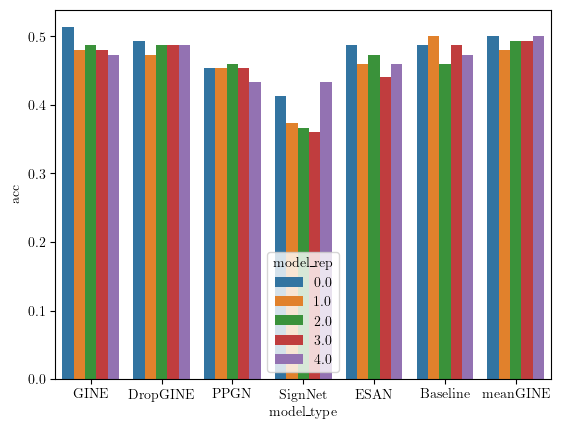

In [4]:
orig_per_model = group(orig_data, ["model"]).mean().reset_index()
append_model_type(orig_per_model)
orig_per_model["budget"] = 0

plot = sns.barplot(data=orig_per_model, x="model_type", y="acc", hue="model_rep")

groupby_to_table(orig_per_model[["model_type", "acc", "lbl_diff"]].groupby("model_type"))

## Bruteforce Data

In [5]:
bf_data = load_data(all_tasks, dataset_name, ["bruteforce"])
pd.pivot_table(bf_data, index=["task", "perturbation"], columns="model_type", aggfunc="count")["y"] # should be 5000 everywhere

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:00<00:00, 1215.02it/s]


model_type               GINE  DropGINE  PPGN  SignNet  ESAN  MeanAggrGINE
task       perturbation                                                   
bruteforce add-edge       750       750   750      750   750           750
           drop-edge      750       750   750      750   750           750

In [6]:
## ADJACENCY PERTURBATION
adjbf_data = remove_unused_categories(bf_data[bf_data["perturbation"].isin(["add-edge", "drop-edge"])])
adjbf_agg = aggregate_over_splits(adjbf_data, group_by=adjbf_data["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
adjbf_agg["task_type"] = "adj_bf"

per_model = group(adjbf_agg, ["model"]).mean().reset_index()
append_model_type(per_model)
per_model = per_model.merge(orig_per_model[["model", "acc", "lbl_diff"]].rename(columns={'acc': 'orig_acc', 'lbl_diff': 'orig_lbl_diff'}), on="model")
per_model["delta_acc"] = per_model["orig_acc"] - per_model["acc"]
per_model["delta_lbl_diff"] = per_model["lbl_diff"] - per_model["orig_lbl_diff"]

groupby_to_table(per_model[["model_type", "acc", "delta_acc", "lbl_diff", "delta_lbl_diff"]].groupby("model_type"))

,model_type,acc,delta_acc,lbl_diff,delta_lbl_diff
0,DropGINE,$0.303 \pm 0.104$,$0.183 \pm 0.099$,$0.452 \pm 0.013$,$0.04 \pm 0.012$
1,ESAN,$0.316 \pm 0.08$,$0.148 \pm 0.074$,$0.446 \pm 0.01$,$0.029 \pm 0.009$
2,GINE,$0.353 \pm 0.045$,$0.133 \pm 0.056$,$0.443 \pm 0.009$,$0.032 \pm 0.009$
3,PPGN,$0.396 \pm 0.008$,$0.055 \pm 0.007$,$0.436 \pm 0.004$,$0.014 \pm 0.003$
4,SignNet,$0.32 \pm 0.052$,$0.069 \pm 0.036$,$0.445 \pm 0.007$,$0.01 \pm 0.006$
5,meanGINE,$0.291 \pm 0.08$,$0.203 \pm 0.085$,$0.451 \pm 0.014$,$0.041 \pm 0.014$


In [7]:
pd.pivot_table(adjbf_agg, index=["perturbation"], columns="model_type", aggfunc="count")["y"]

model_type,GINE,DropGINE,PPGN,SignNet,ESAN,MeanAggrGINE
perturbation,,,,,,
add-edge,243,258,291,210,277,243
drop-edge,507,492,459,540,473,507


## AdjPGD

In [8]:
adjpgd_data = load_data(all_tasks, dataset_name, ["adjpgd"])

pd.pivot_table(adjpgd_data, index=["task"], columns="model_type", aggfunc="count")["y"] # each entry should have 5*5*150=3750 values

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:00<00:00, 265.11it/s]


model_type,GINE,DropGINE,PPGN,SignNet,ESAN,MeanAggrGINE
task,,,,,,
adjpgd_abs,3750,3750,3750,3750,3750,3750
adjpgd_rel,3750,3750,3750,3750,3750,3750


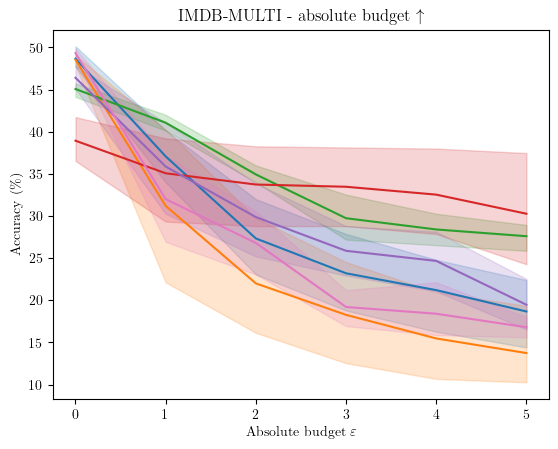

In [9]:
adjpgd_abs_data = remove_unused_categories(adjpgd_data[adjpgd_data["task"].isin(["adjpgd_abs"])]).copy()

per_model = group(adjpgd_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)
# groupby_to_table(per_model[["model_type", "budget", "acc", "lbl_diff"]].groupby(by=["model_type", "budget"]))

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")
per_model = rename_col(per_model, "acc", "accuracy")
per_model["accuracy"] = 100*per_model["accuracy"]

plot = sns.lineplot(data=per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.title("IMDB-MULTI - absolute budget $\\uparrow$")
plot.set_xticks([i for i in range(6)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "IMDB-MULTI_adjpgd_acc_abs.pgf"), bbox_inches='tight')

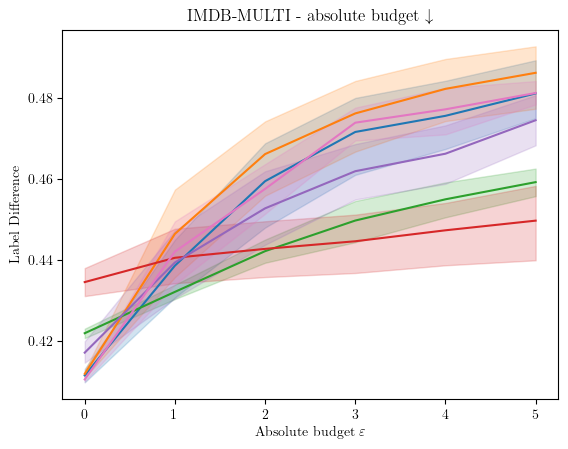

In [10]:
plot = sns.lineplot(data=per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.title("IMDB-MULTI - absolute budget $\\downarrow$")
plot.set_xticks([i for i in range(6)])
plt.legend([], [], frameon=False)
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plot.figure.savefig(osp.join(plots_dir, "IMDB-MULTI_adjpgd_lbl_abs.pgf"), bbox_inches='tight')

In [11]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.pivot_table(per_model[["model", "budget", "expected_budget", "successful_samples"]], values="expected_budget", index="budget", columns="model", aggfunc="mean")

model,DropGINE_0,DropGINE_1,DropGINE_2,DropGINE_3,DropGINE_4,ESAN_0,ESAN_1,ESAN_2,ESAN_3,ESAN_4,GINE_0,GINE_1,GINE_2,GINE_3,GINE_4,MeanAggrGINE_0,MeanAggrGINE_1,MeanAggrGINE_2,MeanAggrGINE_3,MeanAggrGINE_4,PPGN_0,PPGN_1,PPGN_2,PPGN_3,PPGN_4,SignNet_0,SignNet_1,SignNet_2,SignNet_3,SignNet_4
budget,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,0.693340,0.232935,0.762085,0.348128,0.265634,0.687001,0.562198,0.700009,0.236440,0.757560,0.693320,0.700003,0.719983,0.726685,0.733333,0.740006,0.524055,0.700013,0.733325,0.415008,0.666688,0.646678,0.653342,0.263223,0.660004,0.0,0.620005,0.586687,0.653334,0.546681
2.0,0.961191,1.165224,1.144801,1.454935,1.518498,1.244150,1.308535,1.239999,1.294817,1.546693,1.386678,1.400011,1.440014,1.466693,1.092814,1.461602,1.346689,1.065284,1.466666,1.440028,1.333350,1.209195,1.306679,1.400018,1.320004,0.0,1.240006,1.160007,1.306697,1.126647
3.0,1.852501,2.048927,2.204331,2.047996,2.370982,2.080000,1.879324,1.725514,2.139209,2.253318,1.831710,2.100013,1.823923,2.199990,1.765205,2.220021,1.552834,1.501003,2.199994,2.160006,2.000002,1.399767,1.727603,2.100017,1.976939,0.0,1.839990,1.740029,1.973335,1.713325
4.0,2.773366,2.032346,2.994625,2.633640,1.955101,2.005996,2.666713,2.613408,2.039283,2.880692,2.700568,2.793363,2.880033,2.193092,2.933360,2.411541,1.504284,2.780032,2.892025,2.228391,2.507211,2.586699,2.241145,2.800031,2.522248,0.0,2.373368,2.293346,2.606688,2.213333
5.0,3.373357,3.430397,3.047300,3.344430,3.793399,3.373756,3.326690,2.183267,2.861473,3.826641,2.507197,3.201030,2.393575,3.114073,3.660007,3.489682,3.359976,3.466699,3.051956,2.472440,3.095616,3.226670,2.899552,3.487441,2.466488,0.0,2.806652,2.893332,3.206639,2.773319


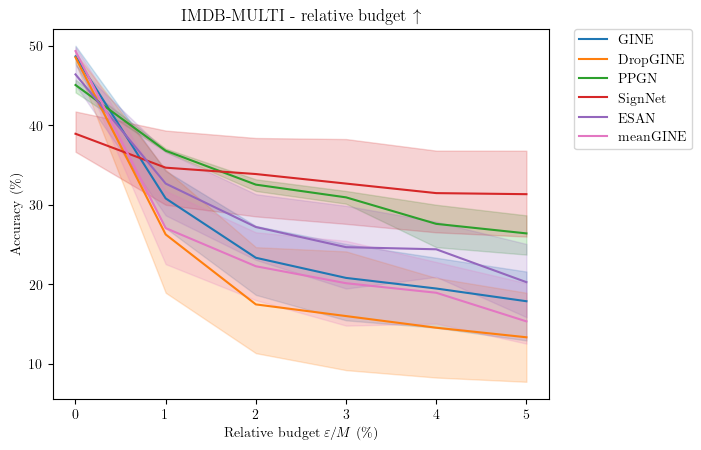

In [12]:
adjpgd_rel_data = remove_unused_categories(adjpgd_data[adjpgd_data["task"].isin(["adjpgd_rel"])]).copy()

per_model = group(adjpgd_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)
# groupby_to_table(per_model[["model_type", "budget", "acc", "lbl_diff"]].groupby(by=["model_type", "budget"]))

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")
per_model = rename_col(per_model, "acc", "accuracy")
per_model["accuracy"] = 100*per_model["accuracy"]

plot = sns.lineplot(data=per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.title("IMDB-MULTI - relative budget $\\uparrow$")
plot.set_xticks([i/100 for i in range(6)])
plot.set_xticklabels([f"{i}" for i in range(6)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "IMDB-MULTI_adjpgd_acc_rel.pgf"), bbox_inches='tight')

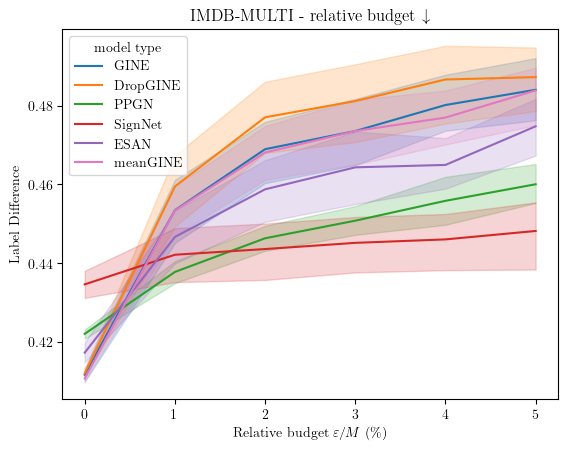

In [13]:
plot = sns.lineplot(data=per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.title("IMDB-MULTI - relative budget $\\downarrow$")
plot.set_xticks([i/100 for i in range(6)])
plot.set_xticklabels([f"{i}" for i in range(6)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Label Difference')
plot.figure.savefig(osp.join(plots_dir, "IMDB-MULTI_adjpgd_diff_rel.pgf"), bbox_inches='tight')

## Random Perturbations

In [14]:
def reduce_data(df):
    groupby = ["model", "task", "budget"]
    df["count"] = df.groupby(groupby)['y'].transform('size')

    per_model = group(df, groupby).mean().reset_index()
    append_model_type(per_model)
    return per_model

tasks = ["add_rdm_undir_edges", "drop_rdm_undir_edges", "rewire_rdm_undir_edges", "rdm_node_attr_change", "rdm_edge_attr_change"]
rdm_data = load_data(all_tasks, dataset_name, tasks, apply_transform=reduce_data)
assert (rdm_data["count"]==750).all()

baseline_data = orig_data[orig_data["model_type"]=="Baseline"]
baseline_acc = baseline_data["acc"].mean()
baseline_lbl_diff = baseline_data["lbl_diff"].mean()
baseline_acc, baseline_lbl_diff

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:01<00:00, 18.18it/s]


(0.48133333333333334, 0.41708162)

,model_type,accuracy,lbl_diff
0,DropGINE,$0.026 \pm 0.025$,$0.032 \pm 0.017$
1,ESAN,$0.003 \pm 0.007$,$0.009 \pm 0.011$
2,GINE,$0.037 \pm 0.033$,$0.044 \pm 0.024$
3,PPGN,$0.0 \pm 0.0$,$0.0 \pm 0.0$
4,SignNet,$0.0 \pm 0.0$,$0.0 \pm 0.0$
5,meanGINE,$0.047 \pm 0.019$,$0.041 \pm 0.012$


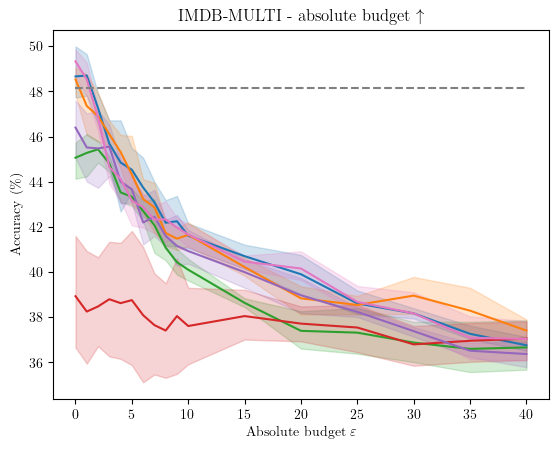

In [15]:
## ADJACENCY - ABS
adjrdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["add_rdm_undir_edges_abs", "drop_rdm_undir_edges_abs"])]).copy()
adjrmd_per_model = group(adjrdm_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(adjrmd_per_model)

adjrmd_per_model = pd.concat([adjrmd_per_model, orig_per_model]).reset_index()
adjrmd_per_model = remove_unused_categories(adjrmd_per_model[adjrmd_per_model["model_type"]!="Baseline"])
adjrmd_per_model = rename_col(adjrmd_per_model, "model_type", "model type")
adjrmd_per_model = rename_col(adjrmd_per_model, "acc", "accuracy")
adjrmd_per_model["accuracy"] = 100*adjrmd_per_model["accuracy"]

plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("IMDB-MULTI - absolute budget $\\uparrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "IMDB-MULTI_rdmadj_acc_abs.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(adjrmd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(adjrmd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "accuracy", "lbl_diff"]].groupby("model_type"))

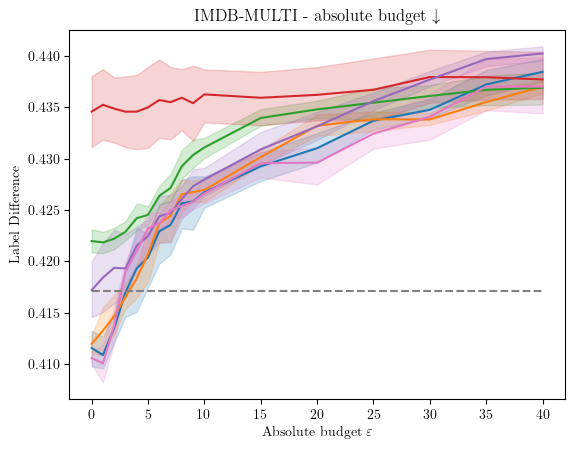

In [16]:
plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("IMDB-MULTI - absolute budget $\\downarrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "IMDB-MULTI_rdmadj_lbl_diff_abs.pgf"), bbox_inches='tight')

,model_type,accuracy,lbl_diff
0,DropGINE,$0.031 \pm 0.031$,$0.023 \pm 0.013$
1,ESAN,$0.006 \pm 0.013$,$0.006 \pm 0.007$
2,GINE,$0.042 \pm 0.039$,$0.03 \pm 0.019$
3,PPGN,$0.0 \pm 0.0$,$0.0 \pm 0.0$
4,SignNet,$0.0 \pm 0.0$,$0.0 \pm 0.0$
5,meanGINE,$0.044 \pm 0.029$,$0.034 \pm 0.009$


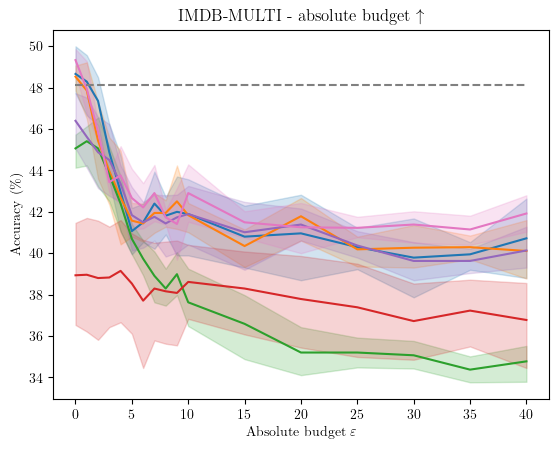

In [17]:
## REWIRE - ABS
rewirerdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rewire_rdm_undir_edges_abs"])]).copy()
rewirermd_per_model = group(rewirerdm_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(rewirermd_per_model)

rewirermd_per_model = pd.concat([rewirermd_per_model, orig_per_model]).reset_index()
rewirermd_per_model = remove_unused_categories(rewirermd_per_model[rewirermd_per_model["model_type"]!="Baseline"])
rewirermd_per_model = rename_col(rewirermd_per_model, "model_type", "model type")
rewirermd_per_model = rename_col(rewirermd_per_model, "acc", "accuracy")
rewirermd_per_model["accuracy"] = 100*rewirermd_per_model["accuracy"]

plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="accuracy", hue="model type", palette=palette) # linestyle=':', 
plt.plot((0, max(rewirermd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("IMDB-MULTI - absolute budget $\\uparrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "IMDB-MULTI_rdmrewire_acc_abs.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(rewirermd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(rewirermd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "accuracy", "lbl_diff"]].groupby("model_type"))

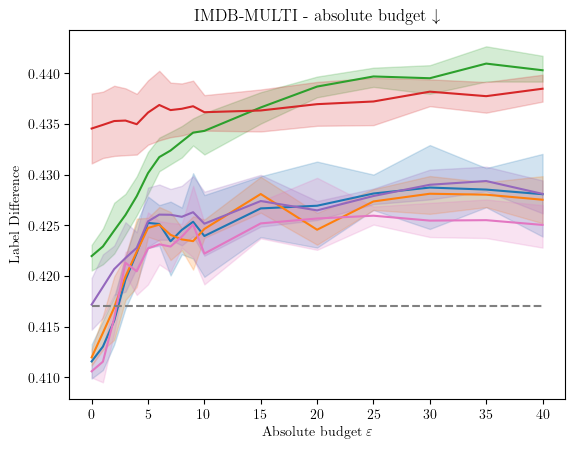

In [18]:
plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette) # linestyle=':', 
plt.plot((0, max(rewirermd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("IMDB-MULTI - absolute budget $\\downarrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "IMDB-MULTI_rdmrewire_lbl_diff_abs.pgf"), bbox_inches='tight')

,model_type,accuracy,lbl_diff
0,DropGINE,$0.02 \pm 0.019$,$0.022 \pm 0.015$
1,ESAN,$0.002 \pm 0.005$,$0.006 \pm 0.008$
2,GINE,$0.024 \pm 0.026$,$0.036 \pm 0.023$
3,PPGN,$0.0 \pm 0.0$,$0.0 \pm 0.0$
4,SignNet,$0.0 \pm 0.0$,$0.0 \pm 0.0$
5,meanGINE,$0.037 \pm 0.018$,$0.034 \pm 0.012$


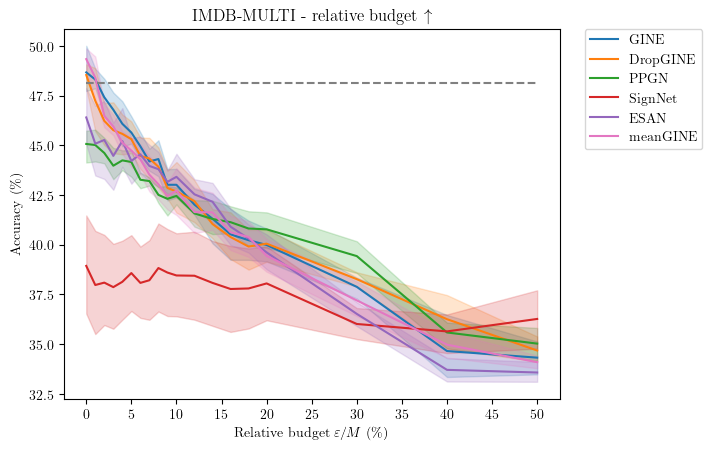

In [19]:
## ADJACENCY - REL
adjrdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["add_rdm_undir_edges_rel", "drop_rdm_undir_edges_rel"])]).copy()
adjrmd_per_model = group(adjrdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(adjrmd_per_model)

adjrmd_per_model = pd.concat([adjrmd_per_model, orig_per_model]).reset_index()
adjrmd_per_model = remove_unused_categories(adjrmd_per_model[adjrmd_per_model["model_type"]!="Baseline"])
adjrmd_per_model = rename_col(adjrmd_per_model, "model_type", "model type")
adjrmd_per_model = rename_col(adjrmd_per_model, "acc", "accuracy")
adjrmd_per_model["accuracy"] = 100*adjrmd_per_model["accuracy"]

plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("IMDB-MULTI - relative budget $\\uparrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon/ M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "IMDB-MULTI_rdmadj_acc_rel.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(adjrmd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(adjrmd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "accuracy", "lbl_diff"]].groupby("model_type"))

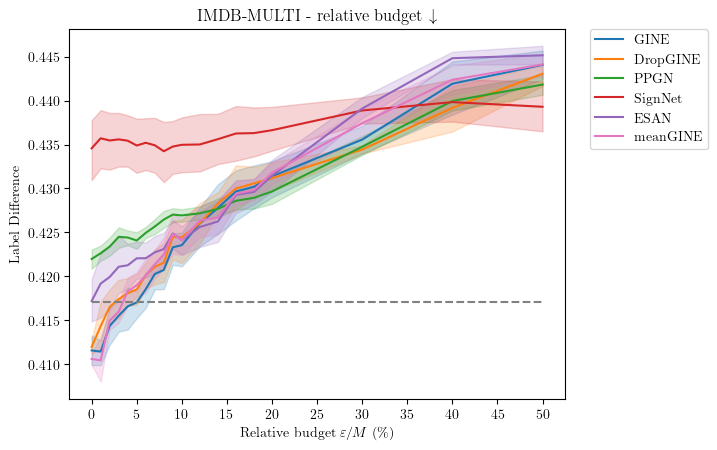

In [20]:
plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("IMDB-MULTI - relative budget $\\downarrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon/ M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "IMDB-MULTI_rdmadj_lbl_diff_rel.pgf"), bbox_inches='tight')

,model_type,accuracy,lbl_diff
0,DropGINE,$0.032 \pm 0.043$,$0.018 \pm 0.013$
1,ESAN,$0.004 \pm 0.008$,$0.003 \pm 0.004$
2,GINE,$0.043 \pm 0.036$,$0.027 \pm 0.022$
3,PPGN,$0.0 \pm 0.0$,$0.0 \pm 0.0$
4,SignNet,$0.0 \pm 0.0$,$0.0 \pm 0.0$
5,meanGINE,$0.031 \pm 0.026$,$0.025 \pm 0.007$


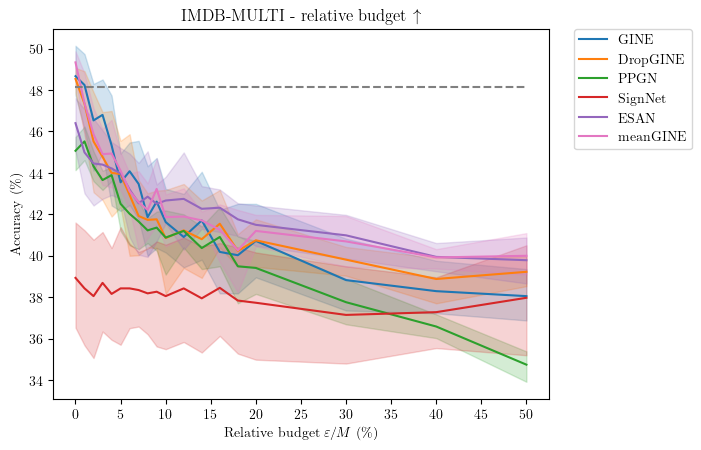

In [21]:
## REWIRE - ABS
rewirerdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rewire_rdm_undir_edges_rel"])]).copy()
rewirermd_per_model = group(rewirerdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(rewirermd_per_model)

rewirermd_per_model = pd.concat([rewirermd_per_model, orig_per_model]).reset_index()
rewirermd_per_model = remove_unused_categories(rewirermd_per_model[rewirermd_per_model["model_type"]!="Baseline"])
rewirermd_per_model = rename_col(rewirermd_per_model, "model_type", "model type")
rewirermd_per_model = rename_col(rewirermd_per_model, "acc", "accuracy")
rewirermd_per_model["accuracy"] = 100*rewirermd_per_model["accuracy"]

plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="accuracy", hue="model type", palette=palette) # linestyle=':',
plt.plot((0, max(rewirermd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("IMDB-MULTI - relative budget $\\uparrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "IMDB-MULTI_rdmrewire_acc_rel.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(rewirermd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(rewirermd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "accuracy", "lbl_diff"]].groupby("model_type"))

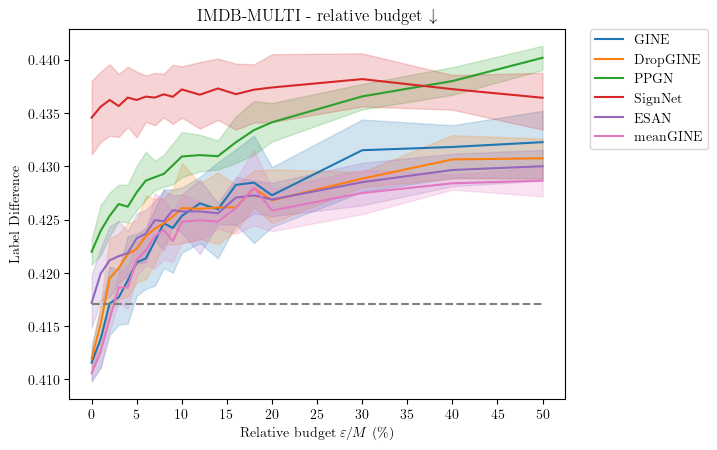

In [22]:
plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette) # linestyle=':',
plt.plot((0, max(rewirermd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("IMDB-MULTI - relative budget $\\downarrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "IMDB-MULTI_rdmrewire_lbl_diff_rel.pgf"), bbox_inches='tight')

## Comparison between PGD and BruteForce

In [27]:
## ADJACENCY COMPARISON
adjpgd_abs_agg = aggregate_over_splits(adjpgd_abs_data, group_by=adjpgd_abs_data["repeat"], shared_cols=["model", "id", "budget"], target_col="lbl_diff")
adjpgd_abs_agg["task_type"] = "adj_pgd_abs"
adjpgd_df = adjpgd_abs_agg[adjpgd_abs_agg["budget"]==1][["model", "id", "lbl_diff", "pred_0", "pred_1", "pred_2"]].rename(columns={'lbl_diff': 'pgd_lbl_diff'})

adjbf_data_ = remove_unused_categories(adjbf_data[adjbf_data["perturbation"].isin(["add-edge", "drop-edge"])]).copy()
adjbf_agg = aggregate_over_splits(adjbf_data_, group_by=adjbf_data_["task"], shared_cols=["model", "id", "perturbation"], target_col="lbl_diff")
adjbf_agg = aggregate_over_splits(adjbf_agg, group_by=adjbf_agg["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
adjbf_agg["task_type"] = "bf"
bf_df = adjbf_agg[["model", "id", "lbl_diff", "pred_0", "pred_1", "pred_2"]].rename(columns={'lbl_diff': 'bf_lbl_diff'})

adj_comparison_df = adjpgd_df.merge(bf_df, on=["model", "id"])
append_model_type(adj_comparison_df)
adj_comparison_df["better"] = adj_comparison_df["pgd_lbl_diff"] > adj_comparison_df["bf_lbl_diff"] - 1e-05
adj_comparison_df["lbl_diff_gap"] = adj_comparison_df["bf_lbl_diff"] - adj_comparison_df["pgd_lbl_diff"]

print(adj_comparison_df.groupby(by="model_type").count()["id"])

per_model = group(adj_comparison_df, ["model"]).mean().reset_index()
append_model_type(per_model)
groupby_to_table(per_model[["model_type", "lbl_diff_gap", "better"]].groupby("model_type"))

model_type
DropGINE    750
ESAN        750
GINE        750
PPGN        750
SignNet     750
meanGINE    750
Name: id, dtype: int64


,model_type,lbl_diff_gap,better
0,DropGINE,$0.005 \pm 0.003$,$0.455 \pm 0.045$
1,ESAN,$0.006 \pm 0.003$,$0.673 \pm 0.08$
2,GINE,$0.005 \pm 0.002$,$0.705 \pm 0.069$
3,PPGN,$0.004 \pm 0.002$,$0.627 \pm 0.061$
4,SignNet,$0.004 \pm 0.003$,$0.705 \pm 0.229$
5,meanGINE,$0.009 \pm 0.005$,$0.673 \pm 0.061$
